# Bayesian Data Analysis Project: U.S. Daily Births
### Team Members: Inon Peled, Niklas Christopher Petersen, Mads Paulsen ;  DTU, 2018.

# Introduction
In this work, we study a time series prediction problem. Our dataset, obtained from [FiveThirtyEight.com](https://github.com/fivethirtyeight/data/tree/master/births), consists of the daily count of births in the United States, from 1-Jan-2000 to 31-Dec-2014. Our goal is to predict the count for each day in 2014, given the daily counts in 2000-2013.

The rest of the notebook is organized as following. First, we explore the dataset and patterns in it. Then, we present baseline models and Stan models. We attempt to gradually yield improved models, namely models with higher prediction accuracy. Finally, we provide a summary of our findings, draw conclusions, and discuss problems and potential improvements.

# Dataset and Goal

### Imports and Commonly Used Symbols

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import pystan
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rcParams['figure.figsize'] = 16, 6
COMMON_SEED = 1234

Before fitting prediction models, let us look into the data we have.

In [4]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


We next assert that no data imputation is needed, i.e. there is a daily count for every day in 2000 to 2014.

In [5]:
def num_days_in_year(year):
    return (datetime(year, 12, 31) - datetime(year, 1, 1)).days + 1


def missing_days(df):
    return births_2000s_df_with_index.groupby('year').births.describe()\
        .assign(expected_days=lambda df: list(map(num_days_in_year, df.index)))\
        .assign(missing=lambda df: df.expected_days - df['count'])

        
assert not any(missing_days(births_2000s_df_with_index).missing)

We next show how births distribute in each year, month, and day of week. We see that whereas the data follows a somewhat steady mean and std. dev. over years and over months, there are is much more variability between days of week:
1. There are numerous outliers in each day of week.
2. There are significantly _less_ births during the weekend (Saturday-Sunday) than during the work week (Monday-Friday).
3. Weekend days have lower variance than work days.

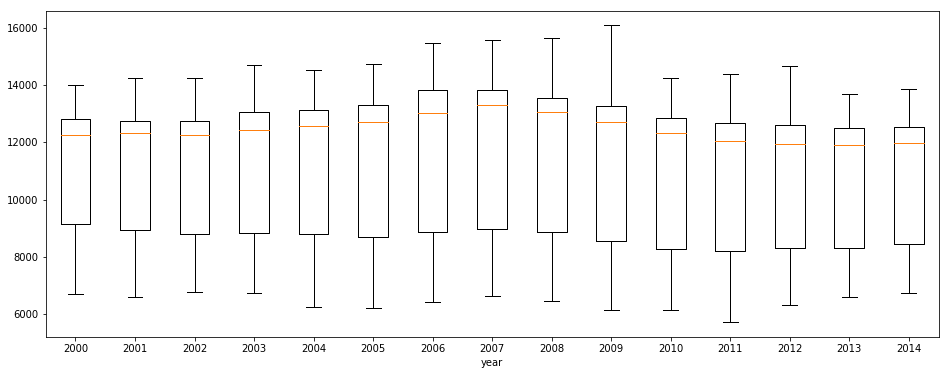

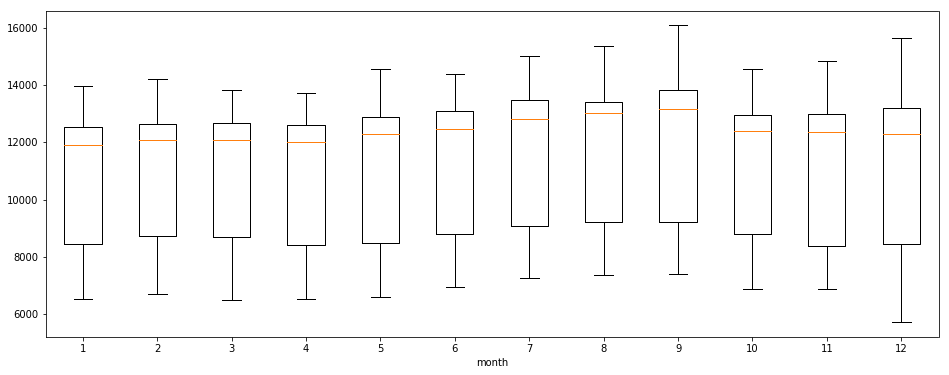

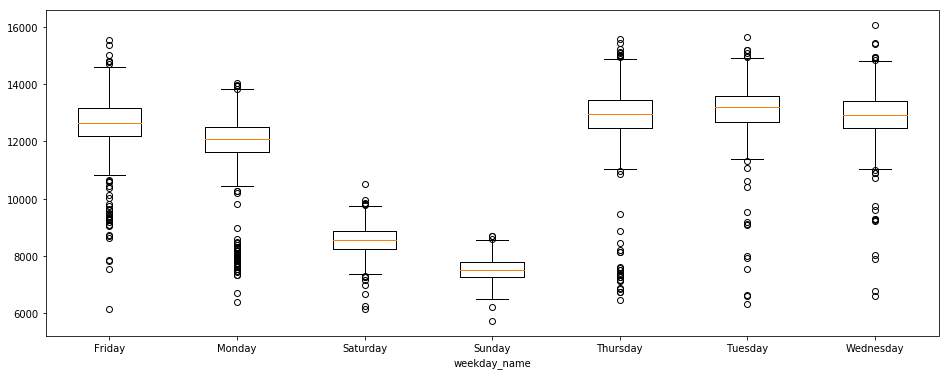

In [6]:
def boxplots(df, time_dimension):
    fig, ax = plt.subplots(1, 1)
    x = sorted(df[time_dimension].unique())
    ax.boxplot([list(df[df[time_dimension] == t].births) for t in x])
    ax.set_xticklabels(x)
    ax.set_xlabel(df[time_dimension].name)

    
for time_dimension in ('year', 'month', 'weekday_name'):
    boxplots(births_2000s_df_with_index, time_dimension)

We also take a look at the distribution of all data points, regardless of time. The distribution is markedly bimodal: one mode for weekend, the other for rest of week. In fact, the weekend distribution is bimodal too, because of differences between Saturday and Sunday.

/home/inonpe/jupyter/dtu_bda_project/env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


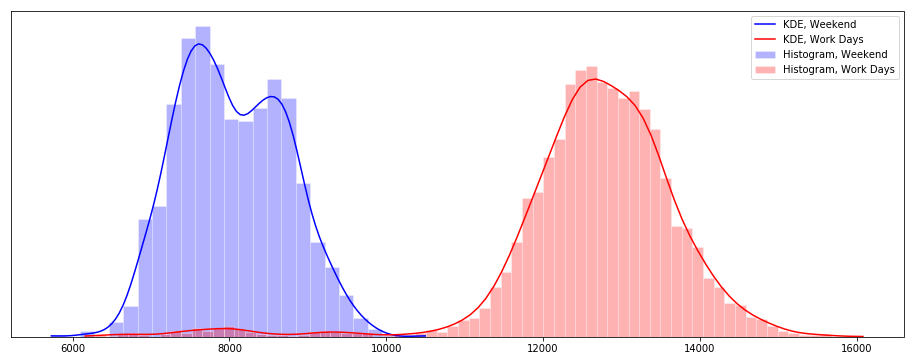

In [7]:
def density_estimation(df):
    fig, ax = plt.subplots(1, 1)
    births_weekend = df.births[df.day_of_week >= 6]
    births_work_days = df.births[df.day_of_week < 6]
    
    ax.hist(births_weekend, bins='auto', facecolor='blue', edgecolor='white', 
            normed=True, label="Histogram, Weekend", alpha=0.3)
    ax.hist(births_work_days, bins='auto', facecolor='red', edgecolor='white', 
            normed=True, label="Histogram, Work Days", alpha=0.3)

    x_kde_weekend = np.linspace(births_weekend.min(), births_weekend.max(), 100)
    ax.plot(x_kde_weekend, gaussian_kde(births_weekend)(x_kde_weekend),
            label="KDE, Weekend", color='blue')

    x_kde_work_days = np.linspace(births_work_days.min(), births_work_days.max(), 100)
    ax.plot(x_kde_work_days, gaussian_kde(births_work_days)(x_kde_work_days), label="KDE, Work Days", color='red')
    
    ax.get_yaxis().set_visible(False)
    ax.legend()
    
density_estimation(births_2000s_df_with_index)

Finally, we turn to look at Gaussian Kernel Density Estimation (KDE) for each weekday separately.

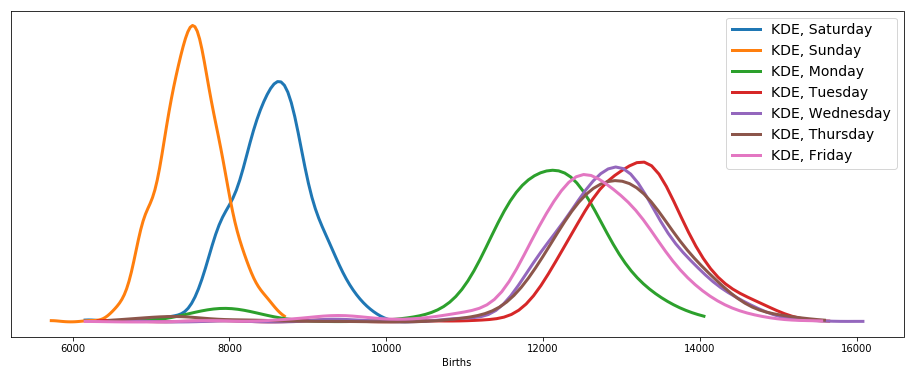

In [8]:
def density_estimation_by_weekday(df):
    fig, ax = plt.subplots(1, 1)
    for d in df.weekday_name.unique():
        daily_births = df.births[df.weekday_name == d]
        x_kde = np.linspace(daily_births.min(), daily_births.max(), 100)
        ax.plot(x_kde, gaussian_kde(daily_births)(x_kde), label="KDE, %s" % d, lw=3)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Births")
    ax.legend(fontsize=14)
    
density_estimation_by_weekday(births_2000s_df_with_index)

## Seasonality
The next few plots are meant to emphasize seasonality in the time series of births. We see that each year follows a similar trend: steady increase in first few months, followed by a peak, a drop, and another peak at end of year.

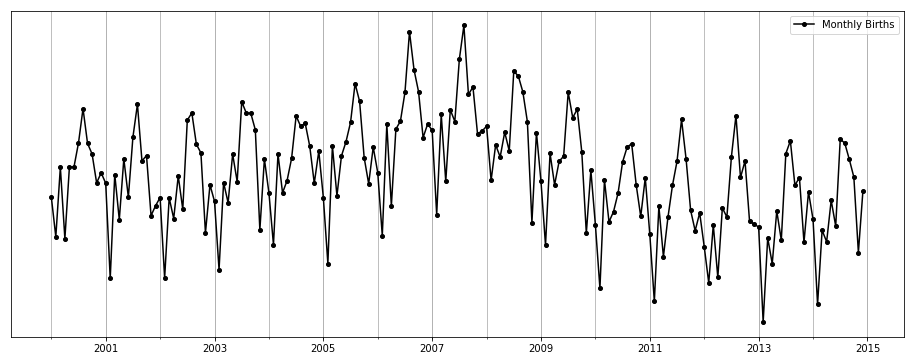

In [9]:
def plot_monthly_births(df):
    d = df.groupby(('year', 'month')).births.sum().reset_index()
    f = pd.to_datetime(d.assign(day=1).drop('births', axis=1))
    ax = d.set_index(f).drop(['year', 'month'], axis=1)\
        .births.rename("Monthly Births")\
        .plot(color="black", marker='o', markersize=4)
    ax.legend()
    ax.grid(which='both')
    ax.get_yaxis().set_visible(False)

plot_monthly_births(births_2000s_df_with_index)

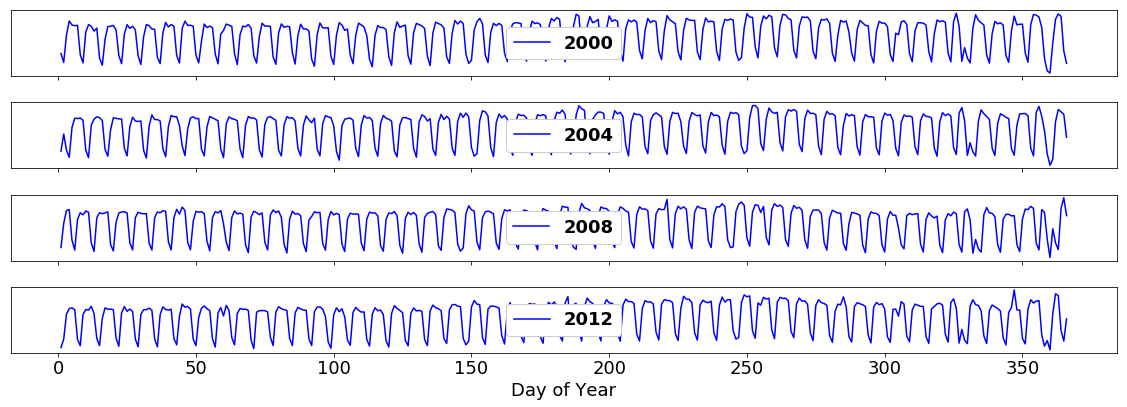

In [10]:
def compare_some_years(years):
    matplotlib.rc('font', **{'size': 18})
    fix, axes = plt.subplots(len(years), 1, sharex=True)
    for i, year in enumerate(years):
        axes[i].plot(
            births_2000s_df_with_index.set_index('day_of_year')[lambda r: r.year == year].births, 
            label=year, color='blue')
        axes[i].legend(prop={'weight':'bold'}, loc='center', framealpha=1)
        axes[i].get_yaxis().set_visible(False)
    axes[-1].set_xlabel("Day of Year")
    plt.tight_layout()
        
compare_some_years(range(2000, 2015, 4))

It is known that people are biased against giving births in some specific dates: holidays, 13th of each month, and 29th Feb. on leap years. However, in this work, we will not involve any contextual information, but rather use only the births data.

## Goal: Analysis Problem
The data story we wish to study is: how well can U.S. daily births in 2014 be predicted?

Our methodology is to gradually imrpove a prediction model. As the next section shows, we will consider two types of models: first models which treat the data as samples from a daily distribution, then models which treat the data as a proper time series.

# Methodology

In this section, we provide some details which apply to all models in this work. First, we describe how we fit each model on the train set, and how we measure its predictive accuracy. Then, we describe our choice of priors and parameters for all Stan models.

## Fitting a Sliding Window

We fit each model repeatedly and independently on each of the first $52$ weeks of year 2014. For each week, we use the immediately preceding $12$ years of data as a train set for fitting. This results in $52$ separate fits, each with its own chain. The fit printouts are therefore very long, hence for legibility, we defer them to appendix 2 at the end of this notebook.

## Prediction Accuracy Measures
To compare the predictive quality of the models, we compute the following.

1. Rooted Mean Squared Error (**RMSE**) of prediction $\hat{y}$ against actual daily counts $y$ in 2014. That is,
$$
RMSE = \sqrt{\frac{1}{364} \sum_{i=1}^{364} \left( \hat{y}_i - y_i \right)^2}
$$
Lower RMSE is better.
1. **Average log-likelihood** of samples from the predictive distribution, where applicable.
Higher log-likelihood is better.

## Stan Priors
In our Stan models, we choose prior disitributions of model parameters as following.
* Cauchy priors for standard deviation parameters, as recommended in the Stan manual.
* Normal priors for other parameters, because natural phenomena in human populations often follow normal distributions.

Some of the models work on standardized ("detrended") data, i.e. for each data point in a train set, we remove the train set mean and then divide by the train set std. dev. The standardized data has mean zero, which we set as the location parameter of prior distributions.

For models which do not use standarized data, we derive the parameters for priors from the mean and std. dev. of year 2000, assuming a reasonable level of stationarity in the time series of births.

## Stan Runtime Parameters
Each Stan model runs the NUTS algorithm with a single chain and $500$ iterations, $\delta = 0.99$, and maximum tree depth $15$. We have found that these Stan parameters usually provide good convergence.

## Stan Convergence Measures
For each model, we check the following convergence conditions, through function "check_convergence" in appendix 1:
* Are all Rhat < $1.1$?
* Have no iterations exceeded the maximum tree depth?
* Is E-BFMI low enough?
* Have only very few iterations ended with divergence?

We also check manually for each model that $neff$, the number of effective samples, is reasonably high.

# Models for Day-of-Week

## Baseline: Historical Average (HA)
As a baseline, we use a historical average model, outside of Stan.

In [7]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.day_of_week[:-7].values,
        'y_train': df.births[:-7].values,
        'x_test': df.day_of_week[-7:].values,
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': array([3, 4, 5, 6, 7, 1, 2], dtype=int64),
 'x_train': array([1, 2, 3, ..., 7, 1, 2], dtype=int64),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310], dtype=int64),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525], dtype=int64)}

In [13]:
def historical_average(x_train, y_train):
    ha = np.empty(7)
    for i in range(7):
        ha[i] = y_train[x_train - 1 == i].mean()
    return ha

historical_average(x, y)

array([11897.83014049, 13122.44444444, 12910.76628352, 12845.82608696,
       12596.16240409,  8562.5734355 ,  7518.37675607])

In [11]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [15]:
def fit_ha_sliding_windows(num_windows):
    prediction_errors = []
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
#         print(data)
        y_pred = historical_average(data['x_train'], data['y_train'])[data['x_test'] - 1].round()
        prediction_errors.append(y_pred - data['y_test'])
#         print(y_pred)
#         print(data['y_test'])
    return np.concatenate(prediction_errors)

rmse(fit_ha_sliding_windows(num_windows=52))

896.5483904862673

We have thus obtained $RMSE = 896.55$ for the baseline HA. This model does not, however, yield any log-likelihood score, because it does not generate a predictive distribution.

## Stan Model 1: Separate, Discretized Normal
In the separate model, each weekday $j$ is given an independent prior $\text{Cauchy}(\mu_j, \sigma_j)$, where $\mu_j$ is equal to the sample mean and $\sigma_j$ is equal to the sample standard deviation for weekday $j$. The observations are then assumed to follow a Normal distribution. This model is thus quite similar to the Separate Machines model from the windshield factory homework.

The predictive distribution is a discretized Normal, so that for $k \in \mathbb{Z}$, the value of the pmf for $k$ is $\Phi(k + 0.5) - \Phi(k - 0.5)$, where $\Phi$ is the cdf of the normally distributed likelihood. This discretization allows us to compare the predictive distribution in this model against discrete distributions in subsequent models.

The following Probabilistic Graphical Model (PGM) also illustrates this model.

![PGM for Stan Model 1: Separate Weekdays. If this image does not display, please see it in https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_separate.png](https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_separate.png)

In [ ]:
model_separate_weekdays = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of predictions.
    int<lower=0> N; // Number of data points.
    vector[N] y_train; // Train data points.
    vector[T] y_test; // Test data points, for log-likelihood.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
    vector[7] prior_means;
    vector[7] prior_stds;
    real<lower=0> V_mu; // Std. dev. for priors on mu.
    real<lower=0> V_sigma; // Std. dev. for priors on sigma.
}
parameters {
    real mu[7];    // Separate means.
    real<lower=0> sigma[7]; // Separate std. devs.
}
model {
    mu ~ normal(prior_means, V_mu * prior_stds);
    sigma ~ normal(prior_stds, V_sigma * prior_stds);
    y_train ~ normal(mu[x_train], sigma[x_train]);
}
generated quantities {
    real loglik;
    vector[T] y_pred;
    loglik = 0;
    for (t in 1:T) {
        y_pred[t] = normal_rng(mu[x_test[t]], sigma[x_test[t]]);
        loglik += log_diff_exp(normal_lcdf(y_test[t] + 0.5 | mu[x_test[t]], sigma[x_test[t]]), normal_lcdf(y_test[t] - 0.5 | mu[x_test[t]], sigma[x_test[t]])); 
    }
}
''')

In [6]:
x = births_2000s_df_with_index.day_of_week.values
y = births_2000s_df_with_index.births.values
N = len(y)
print(x, y, N, sep='\n')

[6 7 1 ... 1 2 3]
[ 9083  8006 11363 ... 12811 13634 11990]
5479


In [ ]:
fit_stan_model_on_sliding_windows(500,
    lambda data: dict(
            prior_means=weekday_priors_by_year_2000()['mean'].values,
            prior_stds=weekday_priors_by_year_2000()['std'].values,
            V_mu=4,
            V_sigma=0.5,            
            x_train=data['x_train'],
            x_test=data['x_test'],
            y_train=data['y_train'],
            y_test=data['y_test'],
            T=7,
            N=len(data['x_train'])),
    'fit_separate', model_separate_weekdays, 52)

Ref. appendix 2 for the long fit details of this model.

{'loglik': -56.40409544595972, 'rmse': 901.4494704644356}

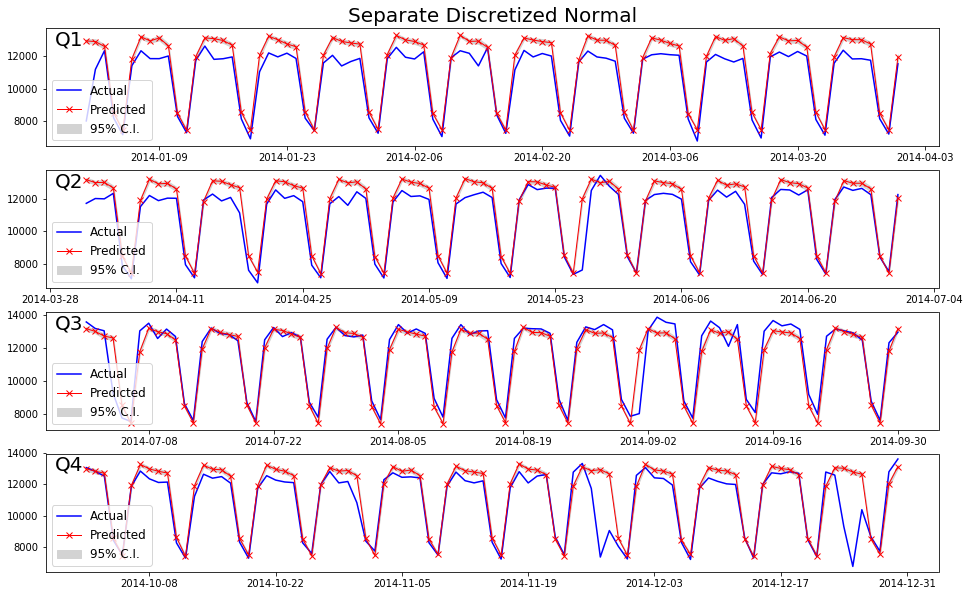

In [8]:
plot_predictions_from_pickled('fit_separate_discretized', 'Separate Discretized Normal')

Stan model 1 thus yields $loglik = -56.40$ and $RMSE = 901.45$, which is a little worse than the baseline HA.

## Stan Model 2: Two Hierarchies, Poisson
In the next model, we try to improve the prediction through two changes. First, we model weekend days separately from work days. For each case, we assume a hierarchical distribution, similarly to the hierarchical models from the windshield factory homework. Second, we model the observed values as Poisson distributed, because it is a discrete distribution of counts. The following PGM also lists the priors we use in this model.

![PGM for Stan Model 2: Hierarchical Poisson. If this image does not display, please see it in https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_hierarchical_poisson.PNG](https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_hierarchical_poisson.PNG)

In [ ]:
model_hier_poisson = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of predictions.
    int<lower=0> N; // Number of data points.
    int y_train[N]; // Train data points.
    int y_test[T]; // Test data points, for log-likelihood.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
    real<lower=0> prior_mean_weekend;
    real<lower=0> prior_mean_workday;
    real<lower=0> prior_std_weekend;
    real<lower=0> prior_std_workday;
    real<lower=0> V_lambda; // Std. dev. for priors on lambda.
    real<lower=0> V_sigma; // Std. dev. for priors on sigma.
}
parameters {
    real<lower=0> lambda[7];
    real<lower=0> lambda_weekend;
    real<lower=0> lambda_workday;
    real<lower=0> sigma_weekend;
    real<lower=0> sigma_workday;
}
model {
    lambda_weekend ~ normal(prior_mean_weekend, V_lambda * prior_std_weekend);
    lambda_workday ~ normal(prior_mean_workday, V_lambda * prior_std_workday);
    sigma_weekend ~ normal(prior_std_weekend, V_sigma * prior_std_weekend);
    sigma_workday ~ normal(prior_std_workday, V_sigma * prior_std_workday);
    lambda[6] ~ normal(lambda_weekend, sigma_weekend);
    lambda[7] ~ normal(lambda_weekend, sigma_weekend);
    for (i in 1:5) {
        lambda[i] ~ normal(lambda_workday, sigma_workday);
    }
    y_train ~ poisson(lambda[x_train]);
}
generated quantities {
    real loglik;
    vector[T] y_pred;
    loglik = 0;
    for (t in 1:T) {
        y_pred[t] = poisson_rng(lambda[x_test[t]]);
        loglik += poisson_lpmf(y_test[t] | lambda[x_test[t]]);
    }
}
''')

In [14]:
def priors_for_weekend_vs_workday_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000\
        .assign(is_weekend=lambda df: df.day_of_week.isin([6, 7]))\
        .groupby('is_weekend')\
        .agg(['mean', 'std'])\
        .births

priors_for_weekend_vs_workday_by_year_2000()
# priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['mean'].values[0]

,mean,std
is_weekend,,
False,12481.507692,909.221295
True,8532.132075,614.062616


In [ ]:
fit_stan_model_on_sliding_windows(
    1000,
    lambda data: dict(
        V_lambda=4,
        V_sigma=0.2,
        prior_mean_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['mean'].values[0],
        prior_mean_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['mean'].values[0],
        prior_std_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['std'].values[0],
        prior_std_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['std'].values[0],
        x_train=data['x_train'],
        x_test=data['x_test'],
        y_train=data['y_train'],
        y_test=data['y_test'],
        T=7,
        N=len(data['x_train'])),
    'fit_hier_poisson', model_hier_poisson, 1)

{'loglik': -287.4199782700962, 'rmse': 897.1197308831815}

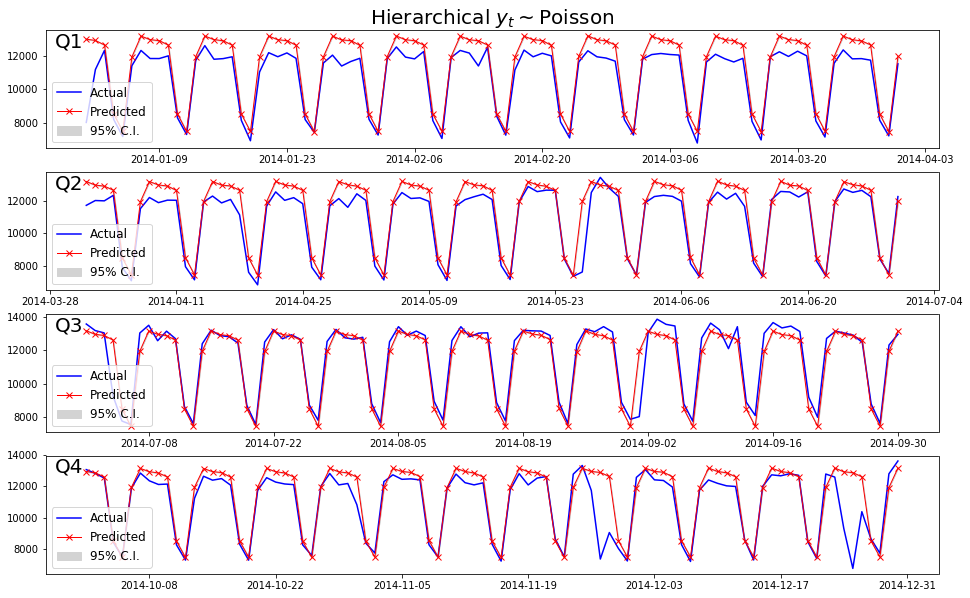

In [29]:
plot_predictions_from_pickled('fit_hier_poisson', 'Hierarchical $y_t \sim$Poisson')

Stan model 2 yields poor predictive accuracy -- RMSE $897.12$ and loglik $-287.42$ -- because the Poisson distribution does not fit well the high over-dispersion in the dataset.

## Stan Model 3: Two Hierarchies, Negative Binomial
To account for over-dispersion, we next attempt to improve model 2 by chaging the likelihood to distribute as Negative Binomial, instead of Poisson. The following PGM also indicates the priors we use for this new model. Locations $\lambda$ for different days are distributed per the two hierarchies in the previous model, while scales $\phi$ for different days are distributed per a single hierarchy.

![PGM for Stan Model 3: Hierarchical Negative Binomial. If this image does not display, please see it in https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_hierarchical_negbin.PNG](https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/pgm_hierarchical_negbin.PNG)

In [8]:
model_hier_negbin = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of predictions.
    int<lower=0> N; // Number of data points.
    int y_train[N]; // Train data points.
    int y_test[T]; // Test data points, for log-likelihood.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
    real<lower=0> prior_mean_weekend;
    real<lower=0> prior_mean_workday;
    real<lower=0> prior_std_weekend;
    real<lower=0> prior_std_workday;
    real<lower=0> V_lambda; // Std. dev. for priors on lambda.
    real<lower=0> V_sigma; // Std. dev. for priors on sigma.
    real<lower=0> V_phi; // Std. dev. for priors on phi.
    real<lower=0> prior_phi;
    real<lower=0> V_daily_phi;
}
parameters {
    real<lower=0> common_phi;
    real<lower=0> phi[7];
    real<lower=0> mu[7];
    real<lower=0> mu_weekend;
    real<lower=0> mu_workday;
    real<lower=0> sigma_weekend;
    real<lower=0> sigma_workday;
}
model {
    common_phi ~ normal(prior_phi, V_phi * prior_phi);
    mu_weekend ~ normal(prior_mean_weekend, V_lambda * prior_std_weekend);
    mu_workday ~ normal(prior_mean_workday, V_lambda * prior_std_workday);
    sigma_weekend ~ normal(prior_std_weekend, V_sigma * prior_std_weekend);
    sigma_workday ~ normal(prior_std_workday, V_sigma * prior_std_workday);
    mu[6] ~ normal(mu_weekend, sigma_weekend);
    mu[7] ~ normal(mu_weekend, sigma_weekend);
    for (i in 1:5) {
        mu[i] ~ normal(mu_workday, sigma_workday);
    }
    phi ~ cauchy(common_phi, V_daily_phi * common_phi);
    y_train ~ neg_binomial_2(mu[x_train], phi[x_train]);
}
generated quantities {
    real loglik;
    vector[T] y_pred;
    loglik = 0;
    for (t in 1:T) {
        y_pred[t] = neg_binomial_2_rng(mu[x_test[t]], phi[x_test[t]]);
        loglik += neg_binomial_2_lpmf(y_test[t] | mu[x_test[t]], phi[x_test[t]]);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1f5534f9f16a420dad5dd0b0607ea807 NOW.


In [9]:
prior_stds = weekday_priors_by_year_2000()['std'].values
prior_mu = weekday_priors_by_year_2000()['mean'].values
prior_phi = (prior_mu ** 2) / (prior_stds ** 2 - prior_mu)
print("prior_stds:", prior_stds, "prior_mu:", prior_mu, "prior_phi:", prior_phi, sep="\n")

prior_stds:
[1036.71590189  790.28995385  422.90591896  813.56700585  634.10553028
  344.64305592  310.30236553]
prior_mu:
[11514.46153846 12870.84615385 12762.26923077 12735.46153846
 12524.5         9049.83018868  8014.43396226]
prior_phi:
[124.69400825 270.82246617 980.66297605 249.85061788 402.66186638
 746.37900747 727.64108437]


In [10]:
def hier_negbin_data_extractor(data):
    return dict(
        V_daily_phi=0.02,
        prior_phi=prior_phi.mean(),
        V_phi=1,
        V_lambda=4,
        V_sigma=0.2,
        prior_mean_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['mean'].values[0],
        prior_mean_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['mean'].values[0],
        prior_std_workday=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == False]['std'].values[0],
        prior_std_weekend=priors_for_weekend_vs_workday_by_year_2000()[lambda df: df.index == True]['std'].values[0],
        x_train=data['x_train'],
        x_test=data['x_test'],
        y_train=data['y_train'],
        y_test=data['y_test'],
        T=7,
        N=len(data['x_train']))

In [ ]:
fit_stan_model_on_plot_predictions_from_pickled('fit_hier_negbin_one_phi', 'Hierarchical $y_t \sim$NegativeBinomial')sliding_windows(
    500,
    hier_negbin_data_extractor,
    'fit_hier_negbin_one_phi', 
    model_hier_negbin,
    52)

Ref. appendix 2 for the long printout of the fit for this model.

{'loglik': -56.67359816246555, 'rmse': 896.8871826563911}

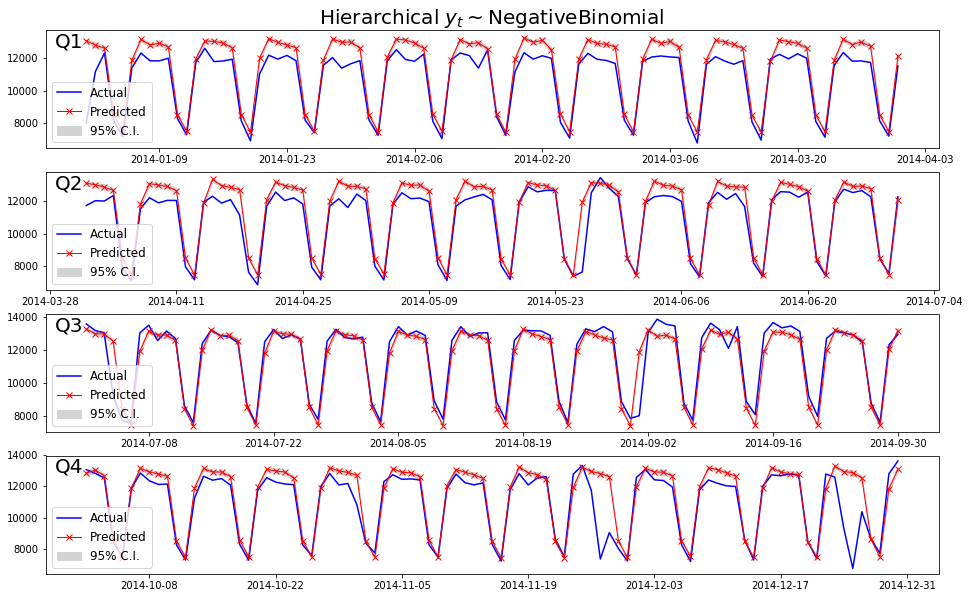

In [30]:
plot_predictions_from_pickled('fit_hier_negbin_one_phi', 'Hierarchical $y_t \sim$NegativeBinomial')

Stan model 3 thus has RMSE $896.89$, which is the best so far, and average log-likelihood very close to the best value, which we obtained in Stan model 1.

# Models for Time Series
Next, we turn to models which account for the time series nature of the dataset. We begin by measuring some properties of the time series, which in turn let us decide on parameter values for the models.

## Preliminary Time Series Analysis

In [18]:
df = births_2000s_df_with_index

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

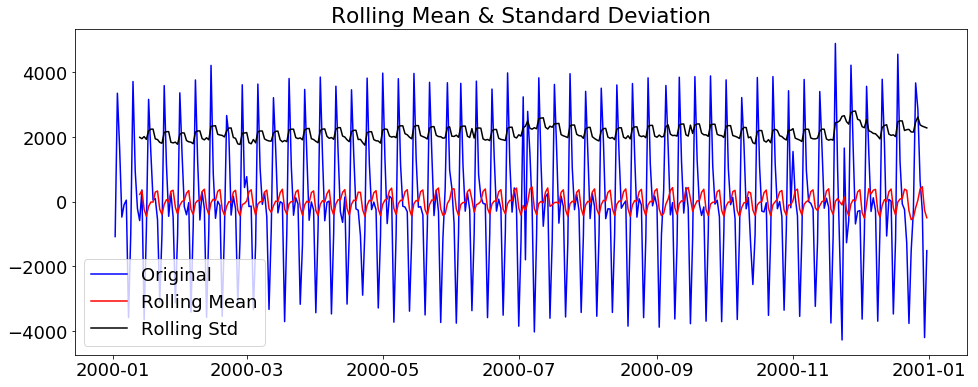

Results of Dickey-Fuller Test:
Test Statistic                -8.596890e+00
p-value                        7.038074e-14
#Lags Used                     1.300000e+01
Number of Observations Used    3.510000e+02
Critical Value (10%)          -2.571176e+00
Critical Value (5%)           -2.869810e+00
Critical Value (1%)           -3.449119e+00
dtype: float64


In [22]:
# test_stationarity(df['births'].diff(1).diff(7).dropna()[:365])
test_stationarity(df['births'].diff(1).dropna()[:365])

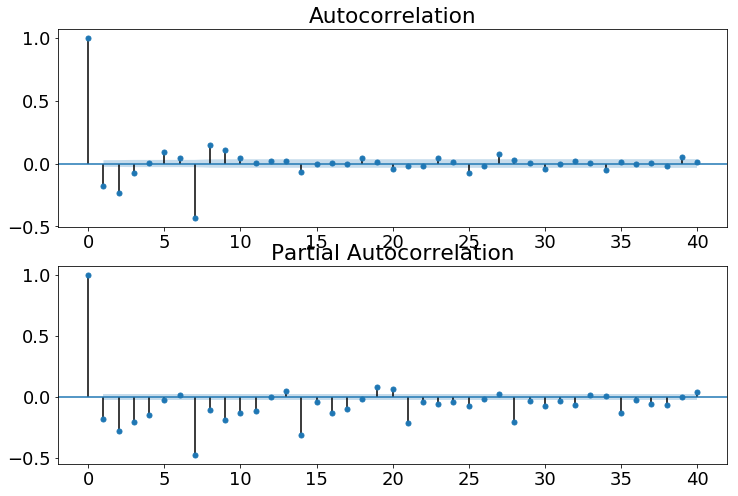

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['births'].diff(1).diff(7)[8:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['births'].diff(1).diff(7)[8:], lags=40, ax=ax2)
plt.show()

Based on the above statistical analysis, we decide to use an ARMA model with AR order $7$ and MA order $1$.

## Baseline: statsmodel.arma
For baseline, we use an ARMA implementation outside of Stan, as following.

In [27]:
priors = arima_priors_by_year_2000()

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [32]:
def statmodels_arima_fit_separate_sliding_windows(persist_path, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []
    priors = arima_priors_by_year_2000()
    for i in range(num_windows):
        if os.path.exists(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i)):
            continue
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        data_train = pd.Series(index = data['x_train'], data = data['y_train'].astype(float))
        data_test = pd.Series(index = data['x_test'], data = data['y_test'].astype(float))
        order = (7, 0, 1)
        model = ARIMA(data_train, order, freq='D')
        model = model.fit()
        print("i = ", i, "model = ", model.summary(), sep="\n")
        y_pred = model.predict(len(data_train), len(data_train) + len(data_test) - 1)
        pred_err = y_pred - data['y_test']
        loglik = model.llf
        all_prediction_errors.append(pred_err)     
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:
            pickle.dump(pred_err, f)        
        with gzip.open(os.path.join(persist_path, 'fit%d_loglik.pkl.gz' % i), 'wb') as f:
            pickle.dump(loglik, f)      

statmodels_arima_fit_separate_sliding_windows(persist_path = 'fit_arima_statmodels', num_windows = 4)

i = 
0
model = 
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 4748
Model:                     ARMA(7, 1)   Log Likelihood              -38836.735
Method:                       css-mle   S.D. of innovations            862.344
Date:                Mon, 16 Apr 2018   AIC                          77693.469
Time:                        11:13:03   BIC                          77758.124
Sample:                    01-01-2001   HQIC                         77716.189
                         - 12-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.138e+04     50.447    225.561      0.000    1.13e+04    1.15e+04
ar.L1.y        0.0718      0.012      6.196      0.000       0.049       0.094
ar.L2.y       -0.0991      0.010    

In [8]:
def statmodels_arima_evaluate_separate_sliding_windows(persist_path, num_windows):
    all_prediction_errors = []
    all_loglik = []
    loglik = 0
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'rb') as f:
            pred_err = pickle.load(f)  
            all_prediction_errors.append(pred_err)
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_loglik.pkl.gz' % i), 'rb') as f:
            params = pickle.load(f)  
            all_loglik.append(params)
            
    print('RMSE          :', rmse(np.concatenate(all_prediction_errors)))
    print('LogLikelyhood :', np.array(all_loglik).mean())

statmodels_arima_evaluate_separate_sliding_windows('fit_arima_statmodels', 52)

RMSE          : 861.5200063770038
LogLikelyhood : -38846.30916573471


This baseline model yields the best RMSE so far: $861.52$.

## Stan Model 4: ARMA
In this model, we try to fit ARMA through Stan. The priors are normally distributed.

In [11]:
%%time

model_arima = pystan.StanModel(model_code='''
data {
  int<lower=1> N;           // number of observations used for fit
  int<lower=1> P;           // number of time lags of the autoregressive model
  int<lower=1> K;           // number of predictions
  real y[N+K];              // observed outputs
  
  real sigma_prior_location;
  real sigma_prior_scale;
}
parameters {
  vector[P] phi;            // autoregression coeff for P lags 
  real theta;               // moving avg coeff for lag 1
  real<lower=0> sigma;      // noise scale
}
model {
  vector[N] nu;             // prediction for time t
  vector[N] err;            // error for time t
  
  // Burn in for y[1..K], e.g. assume lags of y = mu, and err = 0
  for (t in 1:K) {
    for (p in 1:P) {
      nu[t] = 12000;
    }
    err[t] = y[t] - nu[t];
  }
  
  // Fit for y[K+1..N]
  for (t in K + 1:N) {
    nu[t] = 0;
    for (p in 1:P) {
      nu[t] = nu[t] + phi[p] * y[t - p];
    }
    nu[t] = nu[t] + theta * err[t - 1];
    err[t] = y[t] - nu[t];
  }

  // priors
  phi ~ normal(0, 1);
  theta ~ normal(0, 1);
  sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);

  // likelihood
  err ~ normal(0, sigma);
}

generated quantities {
    vector[2 * K] y_pred;
    vector[2 * K] nu_pred;
    vector[2 * K] err_pred;
        
    real loglik = 0;
    
    // Copy the last K values onto new vector, and calculate the err
    for (t in 1:K) {
        y_pred[t] = y[N - K + t];
        nu_pred[t] = 0;
        for (p in 1:P) {
          nu_pred[t] = nu_pred[t] + phi[p] * y[N - K + t - p];
        }
        err_pred[t] = y_pred[t] - nu_pred[t];
    }
    
    // Predictions for the next K time steps.
    for (t in K + 1:2*K) {
        nu_pred[t] = 0;
        for (p in 1:P) {
          nu_pred[t] = nu_pred[t] + phi[p] * y_pred[t - p];
        }
        nu_pred[t] = nu_pred[t] + theta * err_pred[t - 1];
        err_pred[t] = err_pred[t - 1]; // Keep error term, as we don't know the error.
        
        y_pred[t] = normal_rng(nu_pred[t], sigma);        
        
        loglik += normal_lpdf(y[N - K + t] | nu_pred[t], sigma);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_edc957d2394985172b91cc2ec767ae8c NOW.


CPU times: user 1.31 s, sys: 54.5 ms, total: 1.37 s
Wall time: 55 s


In [12]:
def arima_priors_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000.agg(['mean', 'std']).births

In [14]:
%%time

def arima_fit_separate_sliding_windows(persist_path, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []
    priors = arima_priors_by_year_2000()
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        fit = model_arima.sampling(seed=COMMON_SEED, data={
            'sigma_prior_location': priors['std'],
            'sigma_prior_scale': .5 * priors['std'],            
            'N': len(data['y_train']),
            'P': 7,
            'K': len(data['y_test']),
            'y': np.concatenate([data['y_train'], data['y_test']])
        }, iter=500, chains=1)
        check_convergence(fit)
        y_pred = fit.extract()['y_pred'][:,-7:]
        pred_err = y_pred.mean(axis=0) - data['y_test']
        all_prediction_errors.append(pred_err)
        with gzip.open(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.summary(), f)
        with gzip.open(os.path.join(persist_path, 'fit%d_extract.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.extract(), f)         
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:
            pickle.dump(pred_err, f)        

arima_fit_separate_sliding_windows(persist_path='fit_arima', num_windows=52)

In [ ]:
def arima_evaluate_separate_sliding_windows(persist_path, num_windows):
    all_prediction_errors = []
    loglik = 0
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'rb') as f:
            pred_err = pickle.load(f)  
            all_prediction_errors.append(pred_err)
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_extract.pkl.gz' % i), 'rb') as f:
            params = pickle.load(f)  
            loglik += params['loglik'].mean()
    print('RMSE          :', rmse(np.concatenate(all_prediction_errors)))
    print('LogLikelyhood :', loglik)

arima_evaluate_separate_sliding_windows('fit_arima', 52)

1111.2061298212548


{'loglik': -57.78229544327421, 'rmse': 1111.2061298212548}

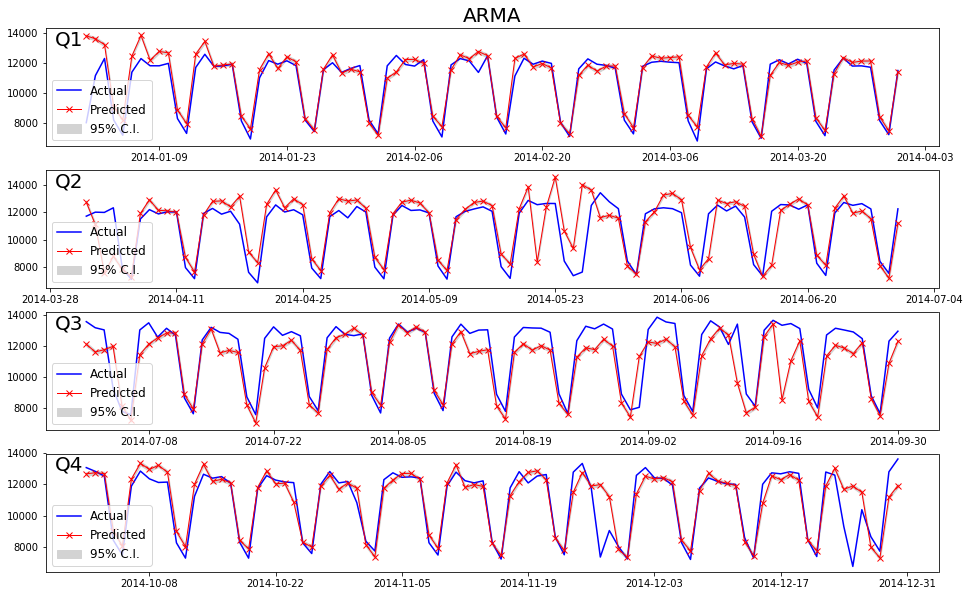

In [33]:
plot_predictions_from_pickled('fit_arima', 'ARMA')

This model does not converge, and we did not have enough time to further improve it. We thus further disregard this model.

## Stan Model 5: FB Prophet
Prophet is a library by Facebook for forecasting time series data. It is based on an additive model, whereby non-linear trends are fit with yearly and weekly seasonality. Prophet works best with daily periodicity data with at least one year of historical data. It is robust to missing data, shifts in the trend, and large outliers.

Behind the scenes, Prophet uses Fourier Series to fit non-linear components of trends with yearly and weekly seasonality, and a linear growth *Stan model* for the overall trend.

In [4]:
from fbprophet import Prophet

In [26]:
from scipy.stats import norm

In [5]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'train': df[:-7].reset_index().rename({'index': 'ds', 'births': 'y'}, axis = 1),
        'test': df[-7:].reset_index().rename({'index': 'ds', 'births': 'y'}, axis = 1)
    }
        
data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

In [58]:
def prophet_fit_separate_sliding_windows(persist_path, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []

    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))

        m = Prophet(daily_seasonality = False)
        m.fit(data['train']);
        
        forecast = m.predict(data['test'])
        
        pred_err = forecast['yhat'] - data['test']['y']
                
        loglik = np.array([
            np.log(norm.cdf(pred_err[i] + 0.5, loc = 0, scale = m.params['sigma_obs'] * m.y_scale) -
                   norm.cdf(pred_err[i] - 0.5, loc = 0, scale = m.params['sigma_obs'] * m.y_scale)) 
            for i in range(7)
        ]).sum(axis = 0).mean()
        
        all_prediction_errors.append(pred_err)     
        with gzip.open(os.path.join(persist_path, 'fit%d_model.pkl.gz' % i), 'wb') as f:
            pickle.dump(m, f)   
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:            
            pickle.dump(pred_err, f)        
        with gzip.open(os.path.join(persist_path, 'fit%d_forecast.pkl.gz' % i), 'wb') as f:
            pickle.dump(forecast, f)   
        with gzip.open(os.path.join(persist_path, 'fit%d_loglik.pkl.gz' % i), 'wb') as f:
            pickle.dump(loglik, f)      

prophet_fit_separate_sliding_windows(persist_path = 'fit_prophet', num_windows = 52)

In [59]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [60]:
def prophet_evaluate_separate_sliding_windows(persist_path, num_windows):
    all_prediction_errors = []
    all_loglik = []
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'rb') as f:
            pred_err = pickle.load(f)  
            all_prediction_errors.append(pred_err)
        with gzip.open(os.path.join(persist_path, 'fit%d_loglik.pkl.gz' % i), 'rb') as f:
            loglik = pickle.load(f)  
            all_loglik.append(loglik)
            
    print('RMSE          :', rmse(np.concatenate(all_prediction_errors)))
    print('Log Likelihood:', np.mean(all_loglik))

prophet_evaluate_separate_sliding_windows('fit_prophet', 52)

RMSE          : 722.5853106888579
Log Likelihood: -56.03629652768643


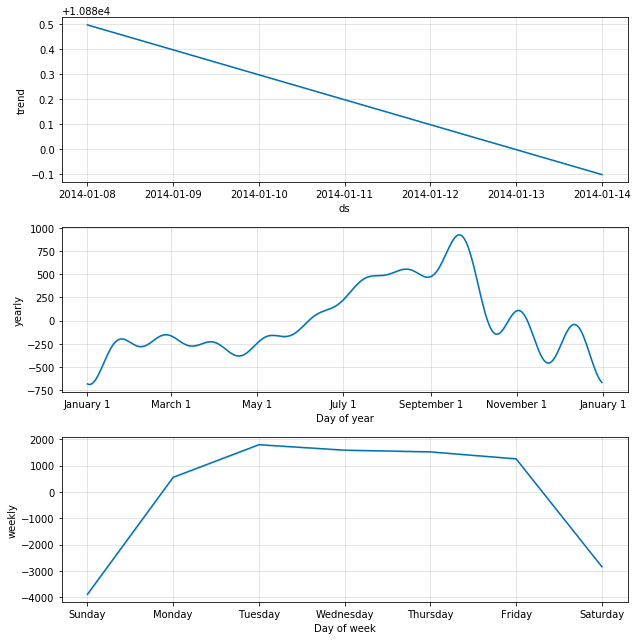

In [10]:
m.plot_components(forecast);

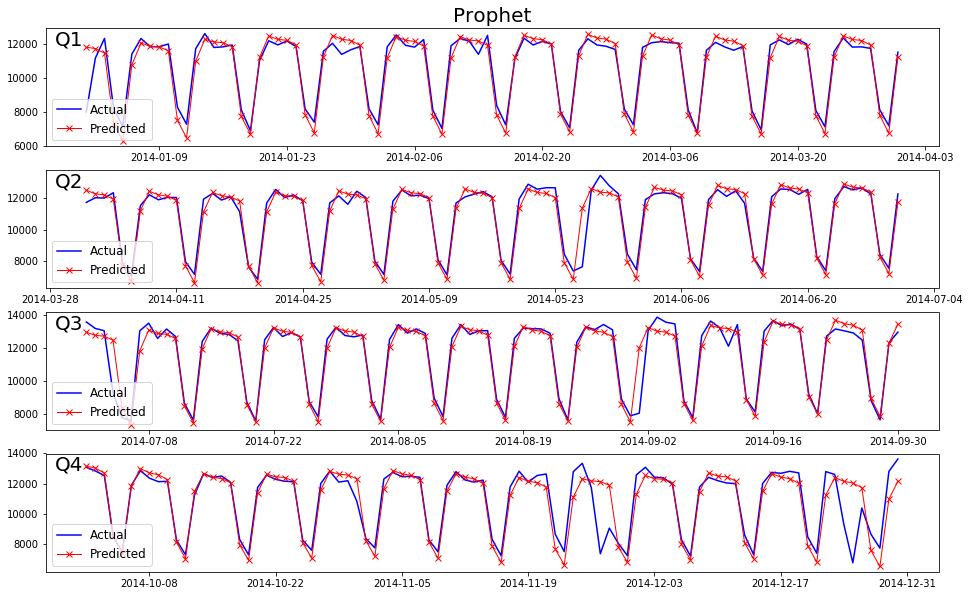

In [29]:
plot_quarterly_no_ci('Prophet', mean_predictions, y_test_2014)

In conclusion, Prophet yields the best RMSE and log-likelihood: $722.59$ and $-56.04$, respectively.

# Conclusions
The next plot compares the predictive accuracy of the baseline and Stan models. We compare only RMSE, which is available for all models, unlike log-likelihood.

![RMSE Comparison. If this image does not display, please see it in https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/summary_rmse.png](https://raw.githubusercontent.com/inon-peled/dtu_bda_project/master/bda_images/summary_rmse.png)

Our main conclusion is that daily number of U.S. births in 2014 could be predicted with a rooted mean squared error at most $723$.

FB Prophet clearly outperforms all other models, and we have also found it to fit much faster than our other Stan models.

We have also obtained that for this dataset, time series models yield much better predictions than day-of-week models. In fact, day-of-week models perform as worse as plain Historical Average.

## Discussion: Problems and Potential Improvements

Modeling in Stan often requires some trial and error. Obtaining the results in this project required quite some tuning of Stan parameters. In particular, our attempt to model ARMA in Stan proved futile for this dataset.

Indeed, Bayesian inference models are appropriate for model-based machine learning, i.e. for testing out different assumptions on how the dataset at hand was generated. If, however, the dataset is assumed to follow a certain parametric model, such as ARMA, it is better to fit the model through a dedicated implementation, rather than approximate the model in Stan.

For additional improvement of predictive accuracy, we suggest the following.
* Account also for yearly seasonality in subsequent models.
* Include additional features, such as national holidays, or contextual information such as socio-economic trends.

# Appendix 1: Utility Functions
The following functions have been used above repeatedly. We have moved these to the end of the notebook for ease of reading.

In [ ]:
def check_convergence(fit, also_print=False):
    report = print if also_print else lambda x: None
    
    def all_rhat_small_enough(fit):
        return all(dict(fit.summary())['summary'][:, -1] < 1.1)
    
    def max_treedepth_exceeded(fit, max_depth = 10):
        """Check transitions that ended prematurely due to maximum tree depth limit"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        depths = [x for y in sampler_params for x in y['treedepth__']]
        n = sum(1 for x in depths if x == max_depth)
        if n > 0:
            report('Run again with max_depth set to a larger value to avoid saturation')        
        N = len(depths)
        report(('{} of {} iterations saturated the maximum tree depth of {}'
               + ' ({}%)').format(n, N, max_depth, 100 * n / N))
        return float(n) / N
    
    def e_bfmi_all_low_enough(fit):
        """
        Checks the energy Bayesian fraction of missing information (E-BFMI).
        E-BFMI below 0.2 indicates you may need to reparameterize your model
        """
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        for chain_num, s in enumerate(sampler_params):
            energies = s['energy__']
            numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
            denom = np.var(energies)
            if numer / denom < 0.2:
                report('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
                report('E-BFMI below 0.2 indicates you may need to reparameterize your model')
                return False
        return True

    def fraction_of_transitions_which_ended_with_divergence(fit):
        """Check transitions that ended with a divergence"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        divergent = [x for y in sampler_params for x in y['divergent__']]
        n = sum(divergent)
        N = len(divergent)
        report('{} of {} iterations ended with a divergence ({}%)'
              .format(n, N, 100 * n / N))
        if n > 0:
            report('Try running with larger adapt_delta to remove the divergences')
        return n / N
    
    assert all_rhat_small_enough(fit)
    assert max_treedepth_exceeded(fit) < 0.02
    assert e_bfmi_all_low_enough(fit)
    assert fraction_of_transitions_which_ended_with_divergence(fit) == 0
    report("##### All convergence checks passed successfully. #####")

In [3]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [4]:
def loglik_from_pickled(dirname):
    return np.concatenate(list(pickle.load(gzip.open(f, 'rb'))['loglik'][:250]
        for f in glob.glob(os.path.join(dirname, 'fit*_extract.pkl.gz')))).mean()

In [5]:
def plot_quarterly(model_name, mean_predictions, ci_95_half_widths, y_test_2014):
    def add_date_index(values):
        return pd.Series(values, 
                         index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30)))
                
    def rmse(prediction_errors):
        return (prediction_errors ** 2).mean() ** 0.5
    
    def filter_date_range(series, from_date_inclusive, to_date_inclusive):
            return series\
                [lambda df: df.index >= from_date_inclusive]\
                [lambda df: df.index < to_date_non_inclusive]
    
    plt.tight_layout()
    for i, (quarter, from_date_inclusive, to_date_non_inclusive) in enumerate([
        ('Q1', datetime(2014, 1, 1), datetime(2014, 4, 1)),
        ('Q2', datetime(2014, 4, 1), datetime(2014, 7, 1)),
        ('Q3', datetime(2014, 7, 1), datetime(2014, 10, 1)),
        ('Q4', datetime(2014, 10, 1), datetime(2014, 12, 31))
    ]):    
        
        plt.subplot(411 + i)
        plt.plot(filter_date_range(y_test_2014, from_date_inclusive, to_date_non_inclusive), "b-", label='Actual', lw=1.5)
        plt.plot(filter_date_range(mean_predictions, from_date_inclusive, to_date_non_inclusive), "r-x", label='Predicted', lw=1)
        plt.fill_between(filter_date_range(y_test_2014, from_date_inclusive, to_date_non_inclusive).index, 
                         filter_date_range(mean_predictions + ci_95_half_widths, from_date_inclusive, to_date_non_inclusive),
                         filter_date_range(mean_predictions - ci_95_half_widths, from_date_inclusive, to_date_non_inclusive),
                         color='lightgrey', label='95% C.I.')
        plt.legend(loc='lower left', fontsize=12)
        plt.text(0.01, 0.9, quarter, fontsize=20,
                 horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        if i == 0:
            plt.title(model_name, fontsize=20)
    
    return rmse(filter_date_range(mean_predictions, datetime(2014, 1, 1), datetime(2014, 12, 31)) -
                filter_date_range(y_test_2014, datetime(2014, 1, 1), datetime(2014, 12, 31)))

In [ ]:
def plot_predictions_from_pickled(results_directory, model_name):
    rcParams['figure.figsize'] = 16, 10
    prediction_samples = np.concatenate(list(pickle.load(gzip.open(f, 'rb'))['y_pred'][:250, -7:]
        for f in glob.glob(os.path.join(results_directory, 'fit*_extract.pkl.gz'))), axis=1)
    sample_size = prediction_samples.shape[0]
    
    def add_date_index(values):
        return pd.Series(values, 
                         index=pd.date_range(start=datetime(2014, 1, 1), end=datetime(2014, 12, 30)))
    
    mean_predictions = add_date_index(prediction_samples.mean(axis=0))
    std_predictions = add_date_index(prediction_samples.std(axis=0))
    ci_95_hw = 1.96 * std_predictions / (sample_size ** 0.5)
    
    births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
    y_test_2014 = births_2000s_df\
        .rename(columns={'date_of_month': 'day'})\
        .set_index(pd.to_datetime(
            births_2000s_df.rename(columns={'date_of_month': 'day'})
            [['year', 'month', 'day']]))\
        .births[lambda df: df.index >= datetime(2014, 1, 1)]
    
    return {
        'rmse': plot_quarterly(model_name, mean_predictions, ci_95_hw, y_test_2014),
        'loglik': loglik_from_pickled(results_directory)
    }

In [7]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.day_of_week[:-7].values,
        'y_train': df.births[:-7].values,
        'x_test': df.day_of_week[-7:].values,
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': array([3, 4, 5, 6, 7, 1, 2], dtype=int64),
 'x_train': array([1, 2, 3, ..., 7, 1, 2], dtype=int64),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310], dtype=int64),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525], dtype=int64)}

In [5]:
def weekday_priors_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000.groupby('day_of_week').agg(['mean', 'std']).births

weekday_priors_by_year_2000()

,mean,std
day_of_week,,
1,11514.461538,1036.715902
2,12870.846154,790.289954
3,12762.269231,422.905919
4,12735.461538,813.567006
5,12524.500000,634.105530
6,9049.830189,344.643056
7,8014.433962,310.302366


# Appendix 2: Fit Details
Below are fit printouts for several Stan models. We moved these to an appendix for better legibiltiy of the notebook, as the fit details are very long.

In [21]:
# Stan Model 1: Separate, Discretized Normal

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.28   4.48  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.27   4.28  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.26   4.18  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4     0.3   4.71  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.01
lambda[4]       1.3e4    0.24   3.72  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8539.2    0.22   3.45 8531.9 8537.0 8539.4 8541.4 8545.9    242    1.0
lambda[6]      7489.1    0.23   3.36 7482.3 7486.8 7489.1 7491.6 7496.0    213   1.02
lambda_weekend 7992.7   26.14 413.29 7138.4 7697.6 8041.1 8298.7 8695.7    250    1.0
lambda_workday  1.3e4    25.0 395.21  1.2

C:\Users\madsp\AppData\Local\conda\conda\envs\mbml\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.23    3.7  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.34   5.36  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.29   4.65  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.27   4.28  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.22   3.49  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8538.4    0.22   3.43 8531.8 8536.0 8538.3 8540.7 8544.2    250    1.0
lambda[6]      7487.8    0.23   3.65 7480.5 7485.6 7488.0 7490.3 7494.9    250    1.0
lambda_weekend 8034.2   30.24 478.18 7111.1 7736.2 8029.1 8335.8 9018.3    250    1.0
lambda_workday  1.3e4   25.85 408.69  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.24   3.73  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250   1.01
lambda[1]       1.3e4    0.27   4.23  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.29   4.56  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.25   4.01  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.28    4.4  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8534.9    0.23   3.65 8528.4 8532.0 8534.9 8537.5 8542.0    250    1.0
lambda[6]      7484.4    0.19   3.04 7478.1 7482.5 7484.4 7486.5 7490.5    250    1.0
lambda_weekend 8053.1    28.0 442.77 7125.0 7754.3 8049.4 8326.7 8971.5    250    1.0
lambda_workday  1.3e4   20.22 319.76  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.22   3.45  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.27   4.27  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4     0.3    4.8  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.29   4.59  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4     0.3   4.71  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8531.3    0.22   3.48 8523.7 8529.3 8531.6 8533.7 8537.8    250    1.0
lambda[6]      7481.7    0.23   3.66 7475.7 7478.7 7481.6 7484.5 7488.8    250   1.01
lambda_weekend 8056.9   28.41 449.19 7164.3 7760.4 8049.0 8367.1 8944.8    250    1.0
lambda_workday  1.3e4   27.64 353.96  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.27   4.25  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.27   4.34  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.31   4.86  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.26   4.15  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.27   4.21  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8527.6    0.25   3.92 8519.4 8525.1 8527.7 8530.3 8534.8    250    1.0
lambda[6]      7478.6    0.22   3.54 7471.8 7476.1 7478.3 7481.0 7485.8    250    1.0
lambda_weekend 8041.4   26.05 411.83 7266.6 7754.3 8034.4 8366.7 8758.3    250    1.0
lambda_workday  1.3e4   21.46 339.24  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.24    3.8  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.25   4.01  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4     0.3   4.68  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4     0.3   4.78  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.27   4.28  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8523.3    0.22   3.48 8517.2 8520.8 8523.7 8525.5 8530.2    250   1.01
lambda[6]      7475.2     0.2   3.14 7468.6 7473.2 7475.1 7477.0 7481.6    250    1.0
lambda_weekend 7995.5   26.15 413.53 7257.7 7698.0 7984.2 8245.0 8855.5    250    1.0
lambda_workday  1.3e4   20.51 324.32  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.27   4.27  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.29   4.56  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.24   3.73  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.27   4.25  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4     0.3   4.19  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    192    1.0
lambda[5]      8519.0    0.22   3.56 8512.4 8516.4 8518.9 8521.4 8526.2    250    1.0
lambda[6]      7473.1    0.25   3.34 7467.1 7470.9 7473.2 7475.3 7479.3    181   1.01
lambda_weekend 8013.4   28.49 450.53 7051.2 7728.8 8043.6 8298.5 8819.7    250    1.0
lambda_workday  1.3e4   27.41 339.07  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.25   3.87  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250   1.01
lambda[1]       1.3e4    0.28   4.43  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.28   4.45  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.27   4.26  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.27   4.27  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8516.9    0.28   3.73 8509.4 8514.3 8516.7 8519.5 8524.8    184    1.0
lambda[6]      7471.1    0.21   3.24 7464.9 7468.8 7471.1 7473.3 7477.1    234    1.0
lambda_weekend 8019.1   30.13 476.33 7116.7 7725.4 8001.5 8362.0 8932.2    250    1.0
lambda_workday  1.3e4   27.65 436.27  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.27   4.25  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.26   4.13  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.27   4.34  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.27   4.27  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.01
lambda[4]       1.3e4    0.25   3.96  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8510.7    0.21   3.36 8504.3 8508.7 8510.9 8512.9 8516.9    250   1.01
lambda[6]      7467.5    0.23   3.42 7460.6 7465.4 7467.4 7470.0 7474.0    220    1.0
lambda_weekend 8006.1   27.88 440.85 7178.5 7688.1 7983.9 8345.7 8867.5    250    1.0
lambda_workday  1.3e4   27.67 437.45  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.29   4.63  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.28   4.37  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.01
lambda[2]       1.3e4    0.28   4.38  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.27    4.3  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.28   4.46  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8508.7    0.23   3.69 8501.3 8506.5 8508.5 8511.0 8516.2    250    1.0
lambda[6]      7466.0    0.19   3.05 7460.6 7463.9 7466.1 7468.2 7472.0    250    1.0
lambda_weekend 7991.3   28.39 448.87 7054.4 7697.7 7977.1 8315.9 8828.3    250    1.0
lambda_workday  1.3e4   25.29 399.91  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.28   4.47  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.37   4.24  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    131    1.0
lambda[2]       1.3e4    0.32   4.22  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    173    1.0
lambda[3]       1.3e4    0.27   4.25  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.27    4.3  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8506.0    0.31   4.01 8498.2 8503.6 8505.9 8508.7 8515.8    167    1.0
lambda[6]      7463.6    0.24   3.53 7456.9 7461.0 7463.8 7466.2 7469.6    211   1.01
lambda_weekend 7984.5   29.41 401.13 7237.8 7700.6 7978.9 8281.9 8797.0    186    1.0
lambda_workday  1.3e4   21.83 345.19  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.27   4.33  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.25   3.88  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.29   4.55  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.31   4.96  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4     0.3   4.81  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8503.5    0.22   3.47 8496.7 8501.2 8503.4 8505.8 8509.9    250    1.0
lambda[6]      7461.3    0.22   3.09 7455.2 7459.2 7461.4 7463.2 7467.2    191    1.0
lambda_weekend  86.54   62.49 108.24   0.03   0.06   0.32 190.94 300.93      3   2.13
lambda_workday  1.2e4  619.84 2629.7 780.

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.26   4.04  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.27   4.31  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.25   4.03  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4    0.25   3.99  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.28    4.5  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8501.8     0.2   3.23 8495.2 8499.5 8501.5 8504.1 8507.9    250    1.0
lambda[6]      7460.8    0.21   3.31 7453.6 7458.6 7460.9 7462.8 7468.6    250    1.0
lambda_weekend 8011.4   26.23 414.71 7250.0 7723.5 7993.5 8321.5 8845.4    250   1.01
lambda_workday  1.3e4   23.74 375.29  1.2

Inference for Stan model: anon_model_0294b1b2b77b3f9a75f1650202255689.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda[0]       1.2e4    0.25   3.91  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
lambda[1]       1.3e4    0.32   5.02  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[2]       1.3e4    0.29   4.59  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[3]       1.3e4     0.3   4.82  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[4]       1.3e4    0.28   4.37  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
lambda[5]      8501.2    0.22    3.4 8494.4 8499.1 8501.1 8503.3 8507.8    250    1.0
lambda[6]      7459.8    0.19   3.03 7454.6 7457.4 7459.6 7461.8 7465.9    250    1.0
lambda_weekend 7988.8   29.69 469.46 6981.0 7700.3 7955.5 8253.1 8937.0    250    1.0
lambda_workday  1.3e4   28.18 393.51  1.2

897.1196294964369

In [13]:
# Stan Model 3: Hierarchical, Negative Binomial%%time

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    172.59    2.09  14.45 146.67 161.96 173.62 182.61 200.77     48   1.02
phi[0]          85.4    0.31   4.45  76.37  82.86  85.14  88.14  95.15    206    1.0
phi[1]        171.93    1.28   10.8 150.16  164.5  172.5 179.38 191.85     71   1.02
phi[2]        184.56     0.9  10.77 162.58  178.5 184.23 191.35 206.66    142    1.0
phi[3]          96.7    0.36   5.08   87.3  93.13   96.1 100.44 107.95    203    1.0
phi[4]        146.36    0.76   9.33 127.32 140.39 145.84 151.99  164.3    152    1.0
phi[5]        294.76    1.38  17.64  260.6  283.8 293.72 305.93  335.6    163    1.0
phi[6]        387.63     2.0   21.1 342.52 375.37  387.6 399.48 429.88    111    1.0
mu[0]          1.2e4    3.24   51.3  1.2e4  1.2e4 

/home/inonpe/jupyter/dtu_bda_project/env/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    168.02    1.41  11.71 145.97 160.16  168.2 176.37 189.26     69    1.0
phi[0]         87.06    0.42   4.96  77.75  83.68   86.7  90.14  99.22    140   1.03
phi[1]        170.31    0.95   9.45 152.03 163.23 170.23 177.36 188.32    100    1.0
phi[2]        176.36    0.88   9.54 158.87 170.07 175.85 182.95 195.67    118    1.0
phi[3]         95.86    0.39   5.32  85.55   92.1  95.95   99.8 106.21    182    1.0
phi[4]        147.77    0.87   8.73 131.06 141.53 147.78 154.28 164.05    100    1.0
phi[5]         296.4    1.05  16.53  266.6 284.34 296.46 308.11 329.64    250    1.0
phi[6]        387.22    1.39  21.91 350.72 369.69 387.75 402.16 432.97    250   1.01
mu[0]          1.2e4     3.7  58.47  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    171.94    1.03  10.13  150.3 165.77 172.88 177.77 192.96     96    1.0
phi[0]         87.28    0.33   4.53  78.96  83.73  87.34  90.28  96.02    184    1.0
phi[1]        172.18    0.78   8.51 156.13 165.89 173.16 177.61 186.93    118    1.0
phi[2]        175.15    0.86   8.59 157.02 169.98 174.91 179.86 193.89     99    1.0
phi[3]         96.33    0.35   5.51  86.99   92.0  96.13 100.31 107.64    250    1.0
phi[4]         147.0    0.81   9.25 129.72 140.33 147.27 153.12 164.96    130   1.01
phi[5]        296.99    1.11  17.53 263.94 284.95 295.86 309.32 332.52    250    1.0
phi[6]        388.56    1.36  21.56 350.68  372.3  387.3 404.04 432.03    250    1.0
mu[0]          1.2e4     2.9  45.84  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    167.65    0.97  10.65 145.57  159.8 167.55 175.71 186.76    121   1.01
phi[0]         86.48     0.3   4.68  78.02  82.99  86.49  89.94  95.59    250    1.0
phi[1]        169.69    0.64   8.87 154.94 163.15 169.22  175.8 188.54    191    1.0
phi[2]        173.75    0.64    8.1 157.21 168.94  173.2 178.87  191.6    158    1.0
phi[3]         95.82    0.35   5.25  86.12  92.66  95.41  99.37 107.04    222    1.0
phi[4]        148.75    0.75   8.82 131.07 142.85 149.38 155.49 164.28    139    1.0
phi[5]        297.98    1.33  17.18 265.09 286.89 298.32  308.8 331.96    168    1.0
phi[6]        388.52    1.52  19.87 350.61 374.69 388.43 402.45  426.3    171    1.0
mu[0]          1.2e4    3.22  50.92  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    168.17    0.99  10.29 145.01 162.29 168.31  174.5  188.8    107   1.01
phi[0]          87.2    0.29   4.62  79.63  84.03  87.06  90.18  96.98    250   1.01
phi[1]        169.36    0.54   8.53 151.72 164.27 169.29 173.98 186.14    250   1.01
phi[2]        172.94    0.62   8.65 156.96 166.87 172.75 178.29 190.34    195    1.0
phi[3]         95.54    0.44   6.36  84.77  90.87  94.78 100.58 107.74    207   1.01
phi[4]        147.21    0.77   9.79 129.71 139.89 147.77 153.45 167.33    163   1.02
phi[5]        295.28     1.1  15.69 264.99 284.89 294.98 306.12 325.75    205    1.0
phi[6]        387.61    1.52  22.12 347.24 371.56 386.37 403.06 433.07    212    1.0
mu[0]          1.2e4    2.74  43.27  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    163.84    1.31  11.24 142.35 156.78 163.98 171.35 186.21     74   1.01
phi[0]         87.47    0.38   5.16   77.7   83.9  87.27  90.75  98.79    184    1.0
phi[1]        166.28    0.84   8.85 149.41 160.11 166.18 172.97  183.4    112   1.01
phi[2]        171.04    0.76   9.28 154.42 164.69 170.34 176.12 189.72    151    1.0
phi[3]         96.07    0.44   5.09  86.24  92.52  96.24  99.88 105.27    137   1.01
phi[4]        147.22    0.68   8.69 128.58 141.84 147.64 153.05 163.47    162   1.01
phi[5]         294.9     0.9  14.22 265.93 285.41 294.86 305.02 322.23    250    1.0
phi[6]        385.98    1.48  19.82 348.72 371.92 385.96 397.95 428.83    180   1.02
mu[0]          1.2e4    3.14  49.64  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi     167.6    1.22  10.68 146.75 160.75  167.7 174.19 188.25     77   1.01
phi[0]         87.47    0.31   4.94   78.7  83.96  87.42  90.96  97.02    250    1.0
phi[1]        168.52    0.85   9.04  152.2 162.95  167.8 174.17 189.23    112    1.0
phi[2]        172.68    0.99   9.06 155.58  166.4 172.83 178.18 192.11     84   1.01
phi[3]         95.06    0.33   5.18  85.83  91.33  94.69  98.31 106.39    250    1.0
phi[4]        146.68    0.83   9.61  127.5 140.84 145.36  153.5 167.13    134   1.01
phi[5]        294.97    1.16  16.97 267.34 281.11 294.03 307.05 329.82    213   1.01
phi[6]        383.15    1.44   22.8 342.33 366.87 382.63 398.28 431.14    250    1.0
mu[0]          1.2e4    2.96  46.86  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    166.76    0.85   9.48 147.12 160.62 166.43 173.58 184.67    124    1.0
phi[0]         86.76    0.32    5.1  76.03  83.61  86.87  90.52  96.88    248    1.0
phi[1]         168.0    0.63    8.4 150.67 162.72 168.21  173.7 183.08    176    1.0
phi[2]        171.82    0.66   9.09 154.85 165.15 171.73  177.6 190.46    189   1.02
phi[3]         94.87    0.34   5.33  84.78  90.97  94.72  98.18 106.15    250    1.0
phi[4]        146.43    0.61   8.54 130.19 140.41 146.62 152.22 163.45    194   1.02
phi[5]        293.74     0.9   14.3 266.09 283.26 293.83 303.43 322.49    250    1.0
phi[6]        382.46     1.3   20.5 341.96 368.81 382.38 394.41 425.24    250    1.0
mu[0]          1.2e4    2.83  44.81  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    164.58     1.5  11.11 141.18 157.87 165.41 172.38 185.07     55    1.0
phi[0]         86.43    0.43   4.61  78.05  83.12   86.5  89.11   95.4    113    1.0
phi[1]        167.74    0.78   8.28 149.53 162.35 167.82 173.64 184.06    114    1.0
phi[2]        169.15    0.81   8.91 151.47 163.24 168.63 175.08 187.32    121    1.0
phi[3]         95.68    0.38   5.23  86.14   91.5  95.39  99.27 105.73    188    1.0
phi[4]        147.04    0.66   8.72 129.38  141.7 147.14 153.25 163.87    177    1.0
phi[5]        291.89    1.55  17.91 258.29 280.52  290.4 303.06 331.06    133   1.02
phi[6]        382.65    1.82  21.44 338.86  368.3 385.08 396.01  427.4    139   1.01
mu[0]          1.2e4    3.13  49.56  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    165.36     0.7   9.02 149.21 159.94 164.68 171.67 181.33    166   1.01
phi[0]         86.89    0.34   4.99   78.2  83.51  86.28  90.66  96.94    220    1.0
phi[1]        166.35    0.66   7.54 154.15 160.59 165.53 172.07 181.75    132    1.0
phi[2]        169.02     0.6   7.84 156.82 162.85 168.75 174.09  186.1    171    1.0
phi[3]         95.78    0.36   5.15   86.5  92.22  95.94  98.83 107.19    201    1.0
phi[4]        148.84    0.83   9.15 130.19 143.94 149.84 154.87 165.49    122    1.0
phi[5]        292.28    1.61  17.68 262.13 280.12 289.94 304.11 326.49    120    1.0
phi[6]        383.68    1.32  20.94 343.15 369.22 383.71 398.91 426.46    250    1.0
mu[0]          1.2e4    3.32  52.46  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    167.39    1.77  13.13 139.22 159.29 168.47 176.54 190.31     55   1.01
phi[0]         87.19    0.39   4.93  78.15  83.86  87.18  90.52  97.55    158   1.01
phi[1]         169.0     0.8   8.92  153.2 162.14 169.95  175.2 186.46    123   1.04
phi[2]        174.29    0.89   9.34 155.55 167.25 173.95 180.77 193.34    111   1.01
phi[3]         95.14    0.46   4.79  85.41  91.84  94.89  98.47 104.66    108    1.0
phi[4]        141.92    0.95   8.28 127.23 136.15 141.38 147.53 159.62     76   1.03
phi[5]        296.44    1.32  16.14 266.08 285.67 295.78 308.62 326.03    150    1.0
phi[6]        386.22    1.67  19.53 349.68  372.3 386.52 399.29  422.4    137    1.0
mu[0]          1.2e4    3.31  52.31  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    165.52    2.13  13.11 141.67 156.69 164.65 173.28 193.58     38   1.01
phi[0]         86.74    0.33   4.62  78.43   83.7  86.54  89.91  96.63    202    1.0
phi[1]         166.6    1.25   9.77 149.87 159.85 165.75 172.96 186.65     61    1.0
phi[2]        175.84    1.37  11.34 157.44 167.22  175.2 184.57 199.35     69   1.01
phi[3]         95.52    0.37   5.88  83.29  91.82  95.57  99.39 106.35    246    1.0
phi[4]        143.51    0.69   8.51 127.32 137.91 144.13 149.15  159.1    152    1.0
phi[5]        294.95    1.14  15.84 268.32 283.02 294.92 305.96 329.81    194    1.0
phi[6]        389.21    1.48  23.39  349.0 373.26 388.67 406.23 434.62    250    1.0
mu[0]          1.2e4    3.23  51.04  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    168.57    1.58  11.09 143.08 162.66 169.25  176.0 187.68     49    1.0
phi[0]         86.08    0.32   5.07  76.68  82.54  85.63  89.88  95.57    250    1.0
phi[1]        169.25    0.88   8.47 150.52 163.34 168.79 175.17 187.39     92    1.0
phi[2]        173.95    0.78   8.24 157.59 167.81 174.31 179.86 190.38    111    1.0
phi[3]         95.29    0.32   5.08  86.17  91.72  95.18  98.87 105.11    250    1.0
phi[4]        143.06    0.69   7.96 127.82 137.63 142.32 148.87 158.31    134    1.0
phi[5]         300.4    1.13   16.4 267.81 288.78 301.03 310.82 328.48    209    1.0
phi[6]        397.83    1.46  22.66  355.5 381.82 396.27 415.95 440.44    241    1.0
mu[0]          1.2e4    3.42  54.05  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    169.78    0.84   9.37 148.12 164.43 170.12 176.77 185.55    123    1.0
phi[0]         87.47    0.33   4.98  76.73  83.64  87.45   91.3  96.67    223    1.0
phi[1]        169.18    0.76   8.86 147.13 163.86 169.18 175.29 184.44    136    1.0
phi[2]        174.03    0.69   8.63 158.41 167.37 173.75 180.05 191.52    156    1.0
phi[3]         95.34    0.32   5.03  85.78  91.91  95.45   98.6  105.0    250    1.0
phi[4]        143.26    0.56   8.18 128.75 137.79 142.88 148.17 158.93    214    1.0
phi[5]        302.52    1.26  18.29 269.99 287.47 302.26  315.9  337.9    211    1.0
phi[6]        399.51     1.5  23.66 356.14 383.47 398.22 414.84 449.24    250    1.0
mu[0]          1.2e4     3.2  50.66  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    168.88     1.7  13.26 142.37  161.0 169.31 175.74 191.41     61   1.01
phi[0]         86.32    0.32    4.4  77.44  83.12  86.62  89.48  95.96    189    1.0
phi[1]        169.08    0.97    8.8 149.65 163.57 168.99  175.4 185.45     83    1.0
phi[2]        174.39    0.66   8.37 159.19 168.17 174.52  179.6 191.77    160    1.0
phi[3]         96.48    0.39   5.54  86.35  92.52  96.74   99.7 107.46    205    1.0
phi[4]        143.68    0.63   8.14 127.23 138.52 143.72 148.82 163.17    167    1.0
phi[5]        303.83    1.31  18.42 268.73 290.37 302.79 318.14 339.71    199   1.01
phi[6]         405.3    1.58  23.38 361.23 390.12 403.97 419.31 455.06    219    1.0
mu[0]          1.2e4    2.98  47.06  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    168.84    1.24  10.43 147.66 162.09 169.48  175.8 188.59     71   1.02
phi[0]         87.26    0.37   5.35  77.33  83.72  86.85  91.37  98.29    212    1.0
phi[1]        170.04    0.86   8.84 152.83 164.34 170.45 176.09 186.96    106   1.01
phi[2]        174.06    0.79   8.95 155.22 167.93 174.31 179.76 190.09    127    1.0
phi[3]          95.8    0.43   5.12  84.68  92.29  96.02  98.86 105.13    142    1.0
phi[4]        142.95    0.71   8.68 125.47 137.84 142.77 148.06 163.83    150    1.0
phi[5]         306.3    1.68  16.01 274.55 296.44 307.17 315.21 340.88     91   1.05
phi[6]        406.65    1.78  23.22 365.57  390.1 405.27 422.17 464.57    171    1.0
mu[0]          1.2e4     3.3  52.13  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    169.98    1.87  12.69  142.0 163.16 171.15 178.21 191.72     46   1.01
phi[0]         86.35    0.47   4.96  75.39  83.37  86.57  89.75  94.33    110   1.01
phi[1]        170.87    0.88   8.79 153.51 165.51 171.19  177.5 186.51    100   1.02
phi[2]         176.4    0.94    9.8 155.57 170.03 177.17 183.55  194.7    108   1.01
phi[3]         95.98    0.34   4.78  86.35  92.47  96.44   99.4 104.69    202    1.0
phi[4]        142.36    0.72   9.29 125.95 135.33 142.11 148.82 160.53    165   1.02
phi[5]        309.23    1.42   18.3 274.29 297.63 309.88 317.91 350.44    167    1.0
phi[6]        404.46    1.69  23.51  361.6 388.39  402.5 422.26 454.83    193    1.0
mu[0]          1.2e4    2.73  43.23  1.2e4  1.2e4 

Inference for Stan model: anon_model_1f5534f9f16a420dad5dd0b0607ea807.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
common_phi    168.68    1.51  11.37 146.35 161.27 169.17 176.18 189.11     57   1.01
phi[0]         86.46    0.46   5.46   77.0  82.45  86.19  90.62  96.95    140    1.0
phi[1]        169.87     0.9   9.03 153.02 163.68 169.71 175.85 189.07    101   1.02
phi[2]        175.25    0.69   9.23 158.38 168.53 175.21 181.41 192.92    179   1.02
phi[3]         94.48    0.38   4.74  85.26   90.7  94.46  97.93 103.19    153    1.0
phi[4]        141.75    0.69   8.49 126.05 135.72 141.95 146.53 159.52    152    1.0
phi[5]        305.13     1.1  17.39 272.44 293.13 304.51 318.06 342.51    250    1.0
phi[6]        408.29    1.68  25.06 361.29 390.31 408.54 423.31 455.55    222    1.0
mu[0]          1.2e4    2.92  46.14  1.2e4  1.2e4 

CPU times: user 8h 46min 59s, sys: 46.2 s, total: 8h 47min 46s
Wall time: 8h 46min 16s


898.590679443399